In [91]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import os
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(r"C:\Users\diogo\Desktop\new_tese_after_git\clean_code\chemosensing\python_scripts")

from my_data_functions import *  # Now it works


In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# functions

In [93]:
import json

def load_data(file_name ):

    with open(file_name, 'r') as f:
        data = json.load(f)
        df = pd.DataFrame(data)

    return df

In [94]:
def get_sample_name_and_sensor(label):
    #check if theres "--"

    if "--" in label:
        sample_name = label.split("--")[0]
        sensor = label.split("--")[1].split("(")[1].split(")")[0]
    else:
        sample_name = label.split("(")[0]
        sensor = label.split("(")[1].split(")")[0]
    return sample_name,sensor

In [95]:
def get_df_from_data(data):
    df = pd.DataFrame()

    for i, row in data.iterrows():
        ids = row.Ids
        vds = row.Vds  # You probably meant Vds here, not row.Ids again
        label, sensor = get_sample_name_and_sensor(row.Curve_id)

        df = pd.concat([
            df,
            pd.DataFrame({
                "ids": [ids],       # list stays in one cell
                #"vds": [vds],       # same here
                "label": [label],
                "sensor": [sensor]
            })
        ], ignore_index=True)

    ids_expanded = df["ids"].apply(pd.Series)
    df = pd.concat([df.drop(columns=["ids"]), ids_expanded], axis=1)
    return df

In [96]:
def melt_df(df, var_to_drop,var_to_keep ):
    label_df = df.drop(var_to_drop, axis=1)
    plot_df = label_df.melt(id_vars=var_to_keep,var_name="point", value_name="value")
    return plot_df

In [97]:
import plotly.express as px
def plot_melted_df(melted_df,hue_):
    # Get Matplotlib's default color cycle as a list
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    sns.scatterplot(
    data=melted_df,
    x="point",
    y="value",
    hue=hue_,
    edgecolor=None,
    zorder=3,
    palette=default_colors
)

    plt.xlabel("point")
    plt.ylabel(r'$I_{DS}$ (A)')
    plt.legend(title="label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

## ml functions

In [98]:
# import models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, cross_val_predict

# grids for gridearch
knn_param_grid = [
    {
        "kneighborsclassifier__n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30,100],
        "kneighborsclassifier__weights": ["uniform", "distance"],
        "kneighborsclassifier__p": [1, 2]  # 1 for Manhattan, 2 for Euclidean
    }
]

dt_param_grid = [
    {
        "decisiontreeclassifier__criterion": ["gini", "entropy"],  # Drop log_loss unless you're doing prob predictions
        "decisiontreeclassifier__splitter": ["best"],
        "decisiontreeclassifier__max_depth": [None, 10, 25,50,75,10],
        "decisiontreeclassifier__min_samples_split": [2, 5,10],
        "decisiontreeclassifier__min_samples_leaf": [1, 5,10],
        "decisiontreeclassifier__max_features": [None, "sqrt"],
        "decisiontreeclassifier__max_leaf_nodes": [None, 5,10],
        "decisiontreeclassifier__random_state": [42]
    }
]




forest_param_grid = [
    {
        "randomforestclassifier__n_estimators": [25,50, 100,200],
        "randomforestclassifier__max_depth": [None, 5,10,20,50],
        "randomforestclassifier__min_samples_split": [2, 5,10,20],
        "randomforestclassifier__min_samples_leaf": [1, 4,10],
        "randomforestclassifier__max_features": ["sqrt"],
        "randomforestclassifier__random_state": [42]
    }
]

svm_param_grid = [
    {
        "svc__C": [0.1, 0.5, 1, 1.5, 2, 3, 5, 8, 10, 15, 20,50],
        "svc__kernel": ["linear", "rbf"],
        "svc__gamma": ["scale", "auto", 1e-3, 1e-2, 0.1],
        "svc__degree": [3, 4, 5],  # Only used if kernel='poly'
        "svc__class_weight": [None, "balanced"],
        "svc__random_state": [42]
    }
]

def fit_halve_grid_search(x,y, pipeline, param_grid):

    search = HalvingGridSearchCV(
        pipeline,
        param_grid,
        factor=4,  # or even smaller like 1.5 for more granular elimination
        cv=5,
        scoring='f1_macro',
        min_resources=150,  # Start with more data
        aggressive_elimination=True,  # Less likely to drop a good model early
        n_jobs=-1,  # Use all cores
        verbose=1
    )


    search.fit(x, y)
    print("\n", cross_val_score(search.best_estimator_, x, y, cv=5).mean())
    alarm()
    return search

def fit_grid_search(x, y, pipeline, param_grid):
    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )

    search.fit(x, y)
    print("\n", cross_val_score(search.best_estimator_, x, y, cv=5).mean())
    alarm()
    return search


def get_bar_plot(df, dataset):

    # Plot setup
    x = np.arange(len(df))  # the label locations
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Bar plots
    score_bars = ax1.bar(x - width/2, df['score'], width, label='Score', color='skyblue', edgecolor='black')
    time_bars = ax2.bar(x + width/2, df['time'], width, label='Time (s)', color='salmon', edgecolor='black')

    # Axes and labels
    ax1.set_xlabel('Modelo', fontsize=12)
    ax1.set_ylabel('Score', color='skyblue', fontsize=12)
    ax2.set_ylabel('Tempo (s)', color='salmon', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['models'], fontsize=11)

    # Annotations
    for bar in score_bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='blue')

    for bar in time_bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='darkred')

    # Aesthetic touch
    fig.suptitle('Performance do modelo em '+  dataset + ': Score vs Tempo', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()



def fit_dataset(df, df_name):
    
    X = df.drop(["sensor","label"], axis=1)
    y = df.label
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

    models = {
        "knn":[KNeighborsClassifier(), knn_param_grid],
        "svm": [SVC(),svm_param_grid],
        "forest":[RandomForestClassifier(), forest_param_grid],
        "trees":[DecisionTreeClassifier(), dt_param_grid],
        }

    fitted_models = []
    time_took = []
    for model in models.keys():
        

        # Make pipeline with scaling (StandardScaler) and KNN classifier
        pipeline = make_pipeline(StandardScaler(),
                                #PCA(n_components=0.99),
                                models[model][0])

        t1 = time.time()
        grid_fit = fit_grid_search(X_train, y_train, pipeline,models[model][1] )
        t2 = time.time()

        fitted_models.append(grid_fit)
        time_took.append(t2-t1)

    scores = []
    best_est = []

    for model in fitted_models:
        scores.append(cross_val_score(model.best_estimator_, X_train, y_train, cv=5).mean())
        best_est.append(model.best_estimator_)

    final_dict = {
        "models":models.keys(),
        "score":scores,
        "time":time_took,
        "best_est":best_est
    }

    results_df = pd.DataFrame(final_dict)

    get_bar_plot(results_df, df_name)

    return results_df




# tests

In [99]:
path = r"C:\Users\diogo\Desktop\new_tese_after_git\eletronica\SMU\my_stuff\final_GUI\GUI-and-data-analysis\Data\Safety_Save"
file_name = "teste_lixiviados_final.json"
data = load_data(os.path.join(path, file_name))
cleaned_data = data.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [100]:
import seaborn as sns

lets merge labels

In [101]:
label_map = {
    'ga_01': 'ga',
    'ga_05': 'ga',
    'ga_1': 'ga',
    'el_01': 'el',
    'el_05': 'el',
    'el_1': 'el',
    'xyl_174': 'xyl',
    'xyl_348': 'xyl',
    'xyl_696': 'xyl',
    'DI_controlo': 'DI'
}

df =get_df_from_data(cleaned_data)
merged_df = df.copy(deep=True)
merged_df['label'] = df['label'].replace(label_map)


In [102]:
merged_melted_df = melt_df(merged_df,"sensor","label")
plot_melted_df(merged_melted_df,"label")

C:\Users\diogo\AppData\Local\Temp\ipykernel_39808\2399291947.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


KeyboardInterrupt: 

C:\Users\diogo\AppData\Local\Temp\ipykernel_39808\2399291947.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


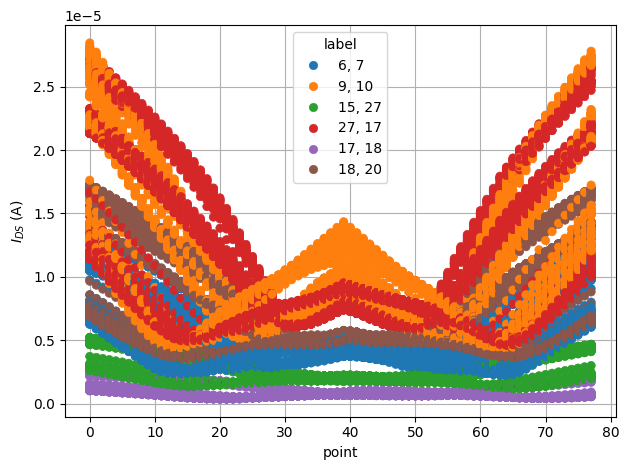

In [ ]:
merged_melted_df = melt_df(merged_df,"label","sensor")
plot_melted_df(merged_melted_df,"sensor")

# machine leanring

In [ ]:
cleaned_data.Curve_id[0:2]

16        DI_controlo(6, 7)
17    DI_controlo--1(9, 10)
Name: Curve_id, dtype: object

In [ ]:
# creating all dfs

# remove the DI water df
no_water_df = get_df_from_data(cleaned_data.drop(range(16,76)))
small_label_df = no_water_df.copy(deep=True)
big_label_df = merged_df.drop(range(60))

xyl_df = no_water_df[no_water_df.label.str[:3] == "xyl"].reset_index(drop=True)
ga_df = no_water_df[no_water_df.label.str[:2] == "ga"].reset_index(drop=True)
el_df = no_water_df[no_water_df.label.str[:2] == "el"].reset_index(drop=True)



In [ ]:
import winsound
def alarm():
    duration = 500  # milliseconds
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(freq, duration)

Fitting 5 folds for each of 56 candidates, totalling 280 fits

 0.9407407407407407
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

 0.8296296296296296
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 0.9333333333333332
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

 0.9012345679012345


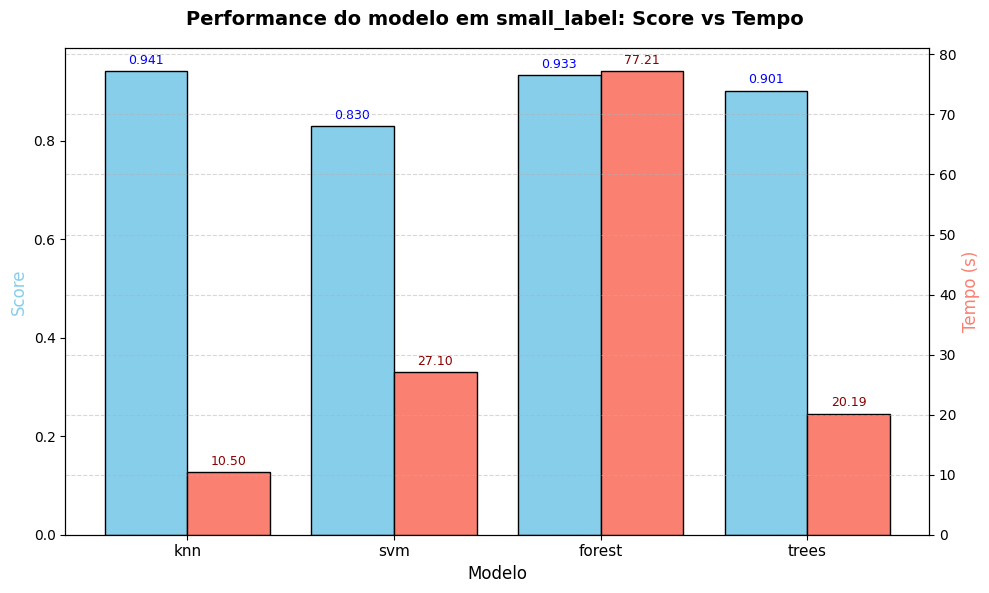

In [ ]:
import time
small_label_results = fit_dataset(small_label_df,"small_label")

Fitting 5 folds for each of 56 candidates, totalling 280 fits

 0.9925925925925926
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

 0.982716049382716
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 0.9925925925925926
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

 0.982716049382716


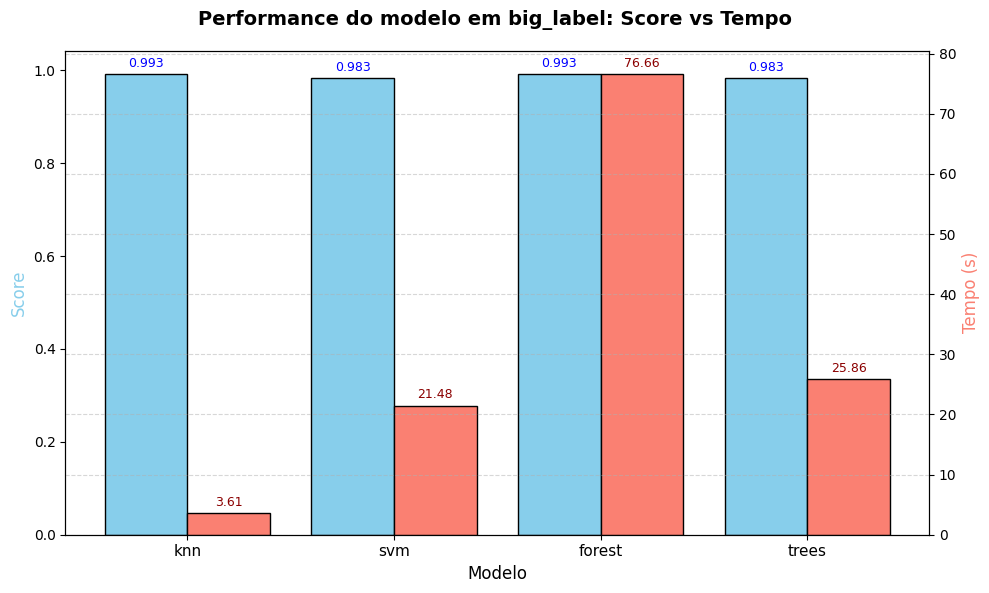

In [ ]:
big_label_results = fit_dataset(big_label_df,"big_label")

Fitting 5 folds for each of 56 candidates, totalling 280 fits



 0.962962962962963
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

 0.8962962962962961
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 0.9481481481481481
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

 0.9111111111111111


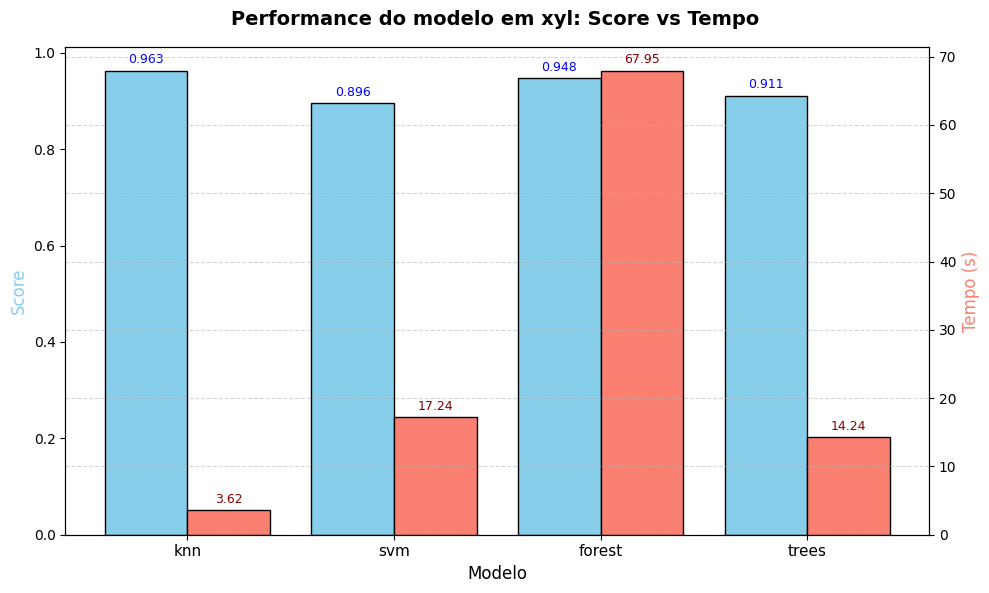

In [ ]:
xyl_results = fit_dataset(xyl_df,"xyl")

Fitting 5 folds for each of 56 candidates, totalling 280 fits

 0.962962962962963
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

 0.9555555555555557
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 0.962962962962963
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

 0.9185185185185185


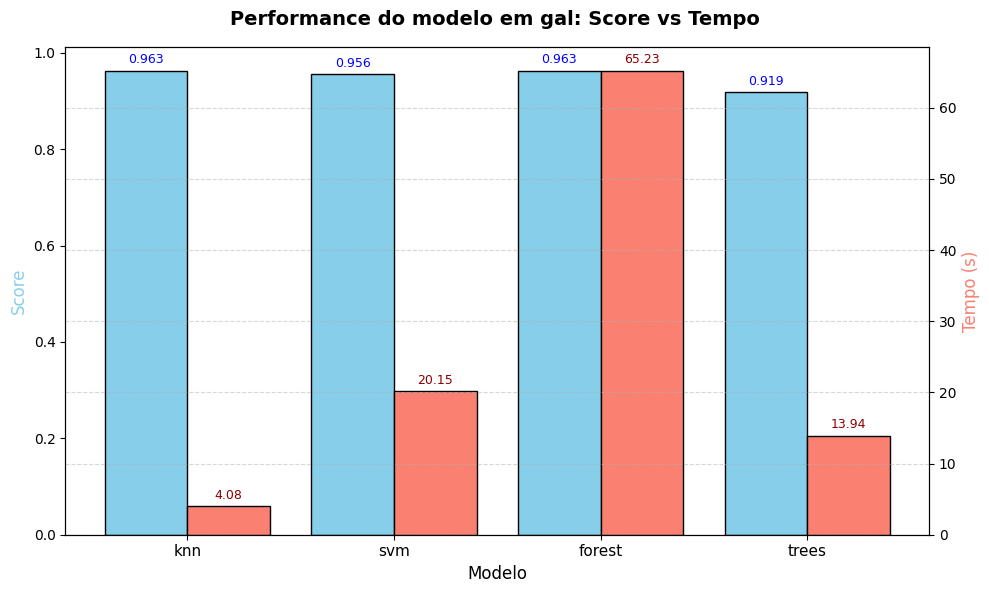

In [ ]:
gal_results = fit_dataset(ga_df,"gal")

Fitting 5 folds for each of 56 candidates, totalling 280 fits

 0.9185185185185185
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

 0.7925925925925925
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

 0.8962962962962961
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

 0.8814814814814815


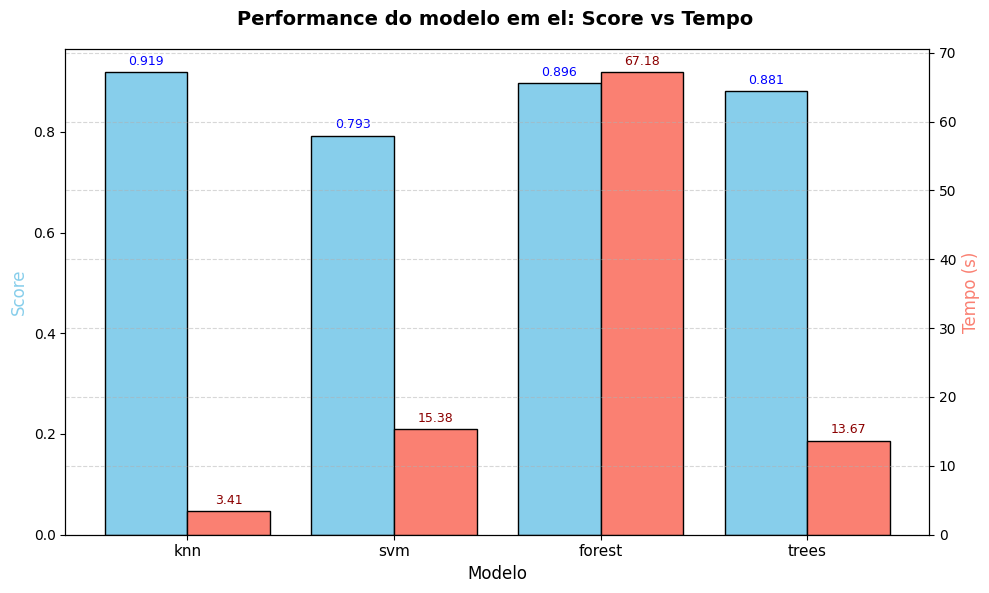

In [ ]:
el_results = fit_dataset(el_df,"el")

In [ ]:
results_dict = {
    "xyl":xyl_results,
    "ga": gal_results,
    "el": el_results,
    "small":small_label_results,
    "big":big_label_results
}

In [ ]:
df = pd.DataFrame()

df["model"] = big_label_results.models

for df_name in results_dict.keys():
    df[df_name+"_score"] = results_dict[df_name].score
    df[df_name+"_time"] = results_dict[df_name].time

In [ ]:
list(results_dict.keys())

['xyl', 'ga', 'el', 'small', 'big']

# Figures to publish

In [ ]:
plt.rcParams.update({
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10
})

## data

In [ ]:
def plot_melted_df(melted_df,hue_,title_,save = False,file_name = None):
    # Get Matplotlib's default color cycle as a list
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    

    sns.scatterplot(
    data=melted_df.sort_values(by=hue_),
    x="point",
    y="value",
    hue=hue_,
    edgecolor=None,
    zorder=3,
    palette=default_colors
)

    plt.xlabel("Index")
    plt.ylabel(r'$I_{DS}$ (A)')
    plt.legend(title=title_)
    plt.grid(True)
    plt.tight_layout()
    if save==True:
        plt.savefig(r"C:\Users\diogo\Desktop\new_tese_after_git\Apoio à escrita\documento_tese\images\chap7\dados_sensor_"+file_name+".png", dpi=300)

    plt.show()
    

In [ ]:
data_to_plot = get_df_from_data(cleaned_data)
label_map = {
    'ga_01': 'ga',
    'ga_05': 'ga',
    'ga_1': 'ga',
    'el_01': 'el',
    'el_05': 'el',
    'el_1': 'el',
    'xyl_174': 'xyl',
    'xyl_348': 'xyl',
    'xyl_696': 'xyl',
    'DI_controlo': 'DI'
}

merged_df = data_to_plot.copy(deep=True)
merged_df['label'] = data_to_plot['label'].replace(label_map)

C:\Users\diogo\AppData\Local\Temp\ipykernel_39808\2523112950.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


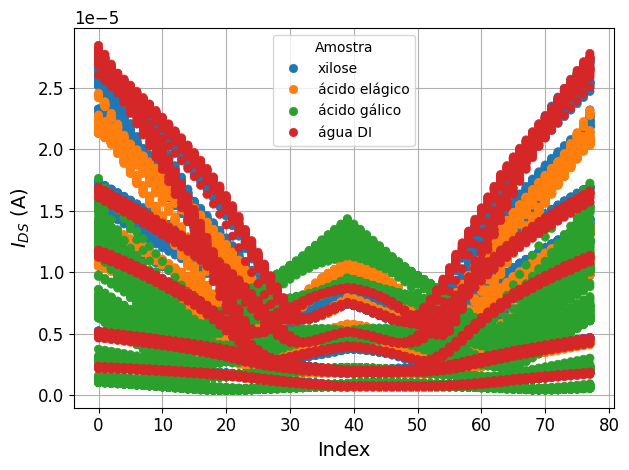

In [ ]:
merged_melted_df = melt_df(merged_df,"sensor","label")
merged_melted_df['label'] = merged_melted_df['label'].replace({
    'DI': 'água DI',
    'el': 'ácido elágico',
    'ga': 'ácido gálico',
    'xyl': 'xilose'
    # add more replacements as needed
})
plot_melted_df(merged_melted_df,"label","Amostra",save = True,file_name="Dados_amostra")

C:\Users\diogo\AppData\Local\Temp\ipykernel_39808\2523112950.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


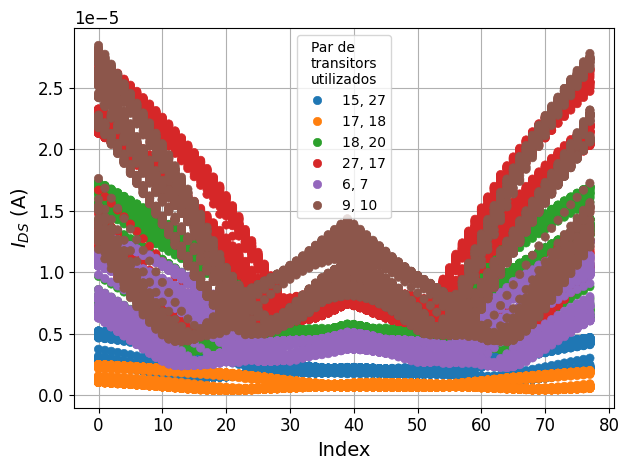

In [ ]:
merged_melted_df = melt_df(merged_df,"label","sensor")
plot_melted_df(merged_melted_df,"sensor","Par de\ntransitors\nutilizados",save = True,file_name = "Dados_sensor")

## ml

In [ ]:
plt.rcParams.update({
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10
})

In [ ]:
df = pd.DataFrame()

df["model"] = big_label_results.models

for df_name in results_dict.keys():
    df[df_name+"_score"] = results_dict[df_name].score
    df[df_name+"_time"] = results_dict[df_name].time

In [ ]:
def data_barplot_with_break(df, results_dict, y_min, legend_loc="best",save=False):
    datasets = list(results_dict.keys())
    models = df['model']
    x = np.arange(len(datasets))
    bar_width = 0.2
    n_models = len(models)

    # Create two subplots for the broken y-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [10, 1]})

    # Y-axis limits
    ax1.set_ylim(y_min, min(1.0, df[[f'{d}_score' for d in datasets]].to_numpy().max() * 1.01))
    ax2.set_ylim(0.0, 0.1)  # Lower part

    for i, model in enumerate(models):
        scores = [df[f'{d}_score'][i] for d in datasets]
        offset = (i - n_models / 2) * bar_width + bar_width / 2

        bars1 = ax1.bar(x + offset, scores, bar_width, label=model, edgecolor='black')
        bars2 = ax2.bar(x + offset, scores, bar_width, edgecolor='black')

        for bar in bars1:
            height = bar.get_height()
            if height > 0.75:
                ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, -5), textcoords="offset points",
                             ha='center', va='top',rotation = 90, fontsize=9)

    # Diagonal break lines
    d = 0.01
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Labels and title
    ax2.set_xlabel('Dataset')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['xyl', 'ga', 'el', 'AG', 'BG'])

    #fig.suptitle('Performance dos modelos por dataset: Score', fontweight='bold')
    ax1.legend(title='Modelo', loc=legend_loc)
    
    ax1.set_ylabel('F1 Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    if save==True:
        plt.savefig(r"C:\Users\diogo\Desktop\new_tese_after_git\Apoio à escrita\documento_tese\images\chap7\dados_sensor_"+"data_bar_plot"+".png", dpi=300)

    plt.show()


In [ ]:
def time_barplot_with_break(df, results_dict, y_min,save=False):
    import matplotlib.pyplot as plt
    import numpy as np

    datasets = list(results_dict.keys())
    models = df['model']
    x = np.arange(len(datasets))
    bar_width = 0.2
    n_models = len(models)

    if y_min > 0:
        # Create two subplots for the broken y-axis
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, 
                                       gridspec_kw={'height_ratios': [10, 1]})

        # Y-axis limits
        max_time = df[[f'{d}_time' for d in datasets]].to_numpy().max()
        ax1.set_ylim(y_min, max_time * 1.05)
        ax2.set_ylim(0.0, 0.1)

        for i, model in enumerate(models):
            times = [df[f'{d}_time'][i] for d in datasets]
            offset = (i - n_models / 2) * bar_width + bar_width / 2

            bars1 = ax1.bar(x + offset, times, bar_width, label=model, edgecolor='black')
            bars2 = ax2.bar(x + offset, times, bar_width, edgecolor='black')

            for bar in bars1:
                height = bar.get_height()
                if height > y_min:
                    ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                                 xytext=(0, -5), textcoords="offset points",
                                 ha='center', va='top',rotation = 90, fontsize=9)

        # Diagonal break lines
        d = 0.01
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (-d, +d), **kwargs)
        ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

        ax2.set_xlabel('Dataset')
        ax1.set_ylabel('Tempo (min)')
        ax2.set_xticks(x)
        ax2.set_xticklabels(['xyl', 'ga', 'el', 'AG', 'BG'])

        fig.suptitle('Performance dos modelos por dataset: Tempo de execução (s)', fontweight='bold')
        ax1.legend(title='Modelo')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)
        ax2.grid(axis='y', linestyle='--', alpha=0.5)

    else:
        # Single-plot version (no break)
        fig, ax = plt.subplots()
        for i, model in enumerate(models):
            times = [df[f'{d}_time'][i]/60 for d in datasets]
            offset = (i - n_models / 2) * bar_width + bar_width / 2
            bars = ax.bar(x + offset, times, bar_width, label=model, edgecolor='black')

            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0,15), textcoords="offset points",
                            ha='center', va='top',rotation = 90, fontsize=9)

        ax.set_ylabel('Tempo (min)')
        ax.set_xlabel('Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(['xyl', 'ga', 'el', 'AG', 'BG'])
        #fig.suptitle('Performance dos modelos por dataset: Tempo de execução (min)', fontweight='bold')
        ax.legend(title='Modelo')
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    if save==True:
        plt.savefig(r"C:\Users\diogo\Desktop\new_tese_after_git\Apoio à escrita\documento_tese\images\chap7\dados_sensor_"+"time_bar_plot"+".png", dpi=300)

    plt.show()

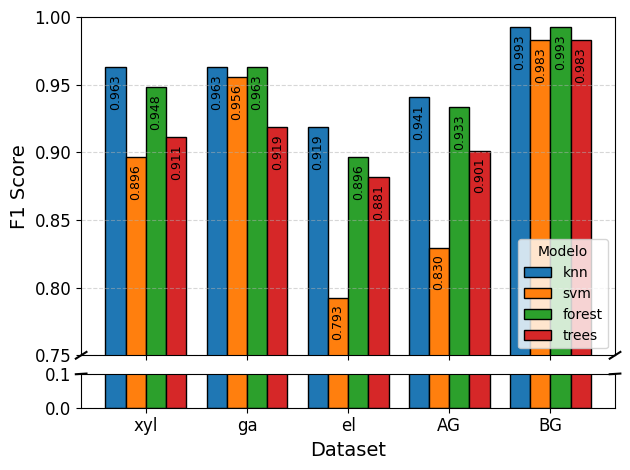

In [ ]:
data_barplot_with_break(df,results_dict,0.75, legend_loc="lower right",save=True)

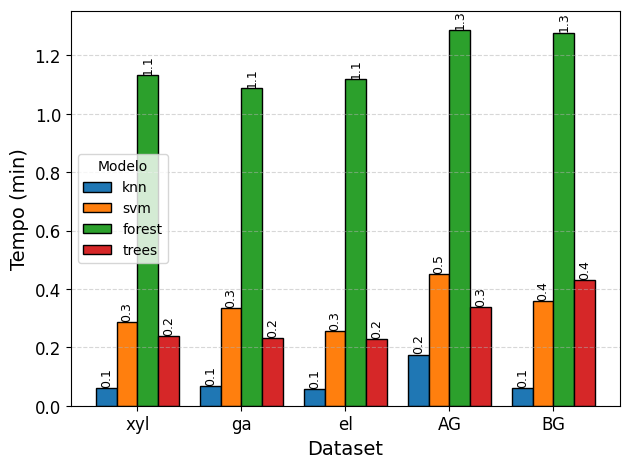

In [ ]:
time_barplot_with_break(df, results_dict, 0,save=True)

simple curve

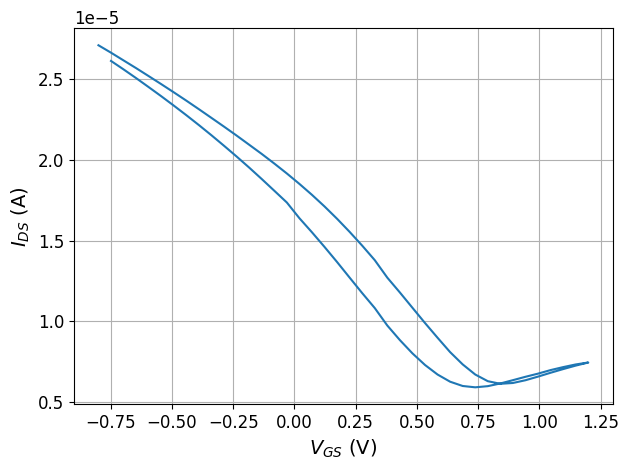

In [ ]:
i = 21
vgs = cleaned_data.iloc[i].Vgs
ids = cleaned_data.iloc[i].Ids

plt.plot(vgs,ids)


plt.xlabel(r'$V_{GS}$ (V)')
plt.ylabel(r'$I_{DS}$ (A)')
plt.grid(True)
plt.tight_layout()

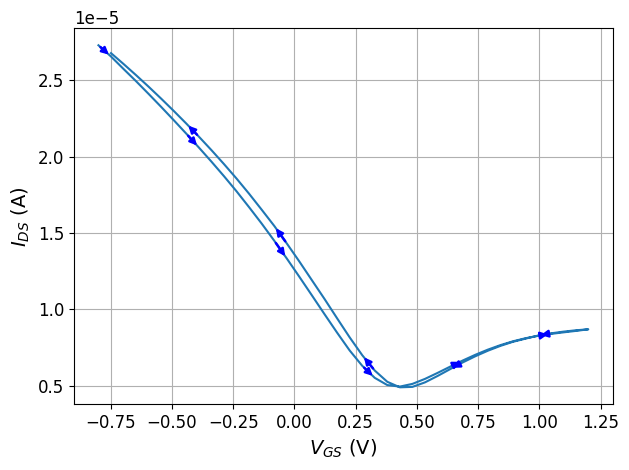

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i = 7
vgs = cleaned_data.iloc[i].Vgs
ids = cleaned_data.iloc[i].Ids

plt.plot(vgs, ids, label='Transfer curve')

# Add arrows at regular intervals
step = len(vgs) // 10  # choose how many arrows
for j in range(0, len(vgs) - step, step):
    dx = vgs[j+1] - vgs[j]
    dy = ids[j+1] - ids[j]
    plt.annotate('', xy=(vgs[j+1], ids[j+1]), xytext=(vgs[j], ids[j]),
                 arrowprops=dict(arrowstyle="-|>", color='blue', lw=1.8))

plt.xlabel(r'$V_{GS}$ (V)')
plt.ylabel(r'$I_{DS}$ (A)')
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Users\diogo\Desktop\new_tese_after_git\Apoio à escrita\documento_tese\images\chap7\histerese.png", dpi=300)

plt.show()


Confusion matrices

In [ ]:
big_label_results

,models,score,time,best_est
0,knn,0.992593,3.609619,"(StandardScaler(), KNeighborsClassifier(n_neig..."
1,svm,0.982716,21.481219,"(StandardScaler(), SVC(C=50, class_weight='bal..."
2,forest,0.992593,76.663738,"(StandardScaler(), (DecisionTreeClassifier(max..."
3,trees,0.982716,25.859303,"(StandardScaler(), DecisionTreeClassifier(rand..."


In [ ]:
small_label_results

,models,score,time,best_est
0,knn,0.940741,10.500412,"(StandardScaler(), KNeighborsClassifier(n_neig..."
1,svm,0.829630,27.095644,"(StandardScaler(), SVC(C=50, kernel='linear', ..."
2,forest,0.933333,77.206429,"(StandardScaler(), (DecisionTreeClassifier(max..."
3,trees,0.901235,20.185044,"(StandardScaler(), DecisionTreeClassifier(max_..."


Macro-averaged F1-score: 0.9927


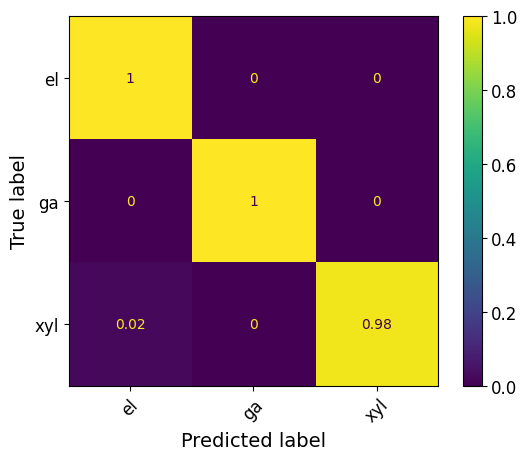

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

knn_best_model=big_label_results.iloc[0].best_est
# Predict
y_pred = knn_best_model.predict(X_test)

# Compute normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_best_model.classes_, normalize='true')

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_best_model.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)

# F1-score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro-averaged F1-score: {f1:.4f}")


In [ ]:
y_test

289     el
133    xyl
581     ga
146    xyl
529     ga
      ... 
184    xyl
441     ga
264     el
232    xyl
271     el
Name: label, Length: 135, dtype: object

Macro-averaged F1-score: 0.9560


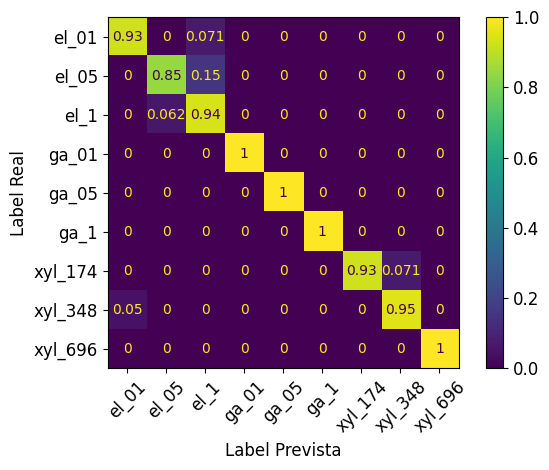

In [ ]:
df = small_label_df
X = df.drop(["sensor","label"], axis=1)
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

knn_best_model=small_label_results.iloc[0].best_est
# Predict
y_pred = knn_best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=knn_best_model.classes_, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_best_model.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)

# Change axis labels
disp.ax_.set_xlabel("Label Prevista", fontsize=12)
disp.ax_.set_ylabel("Label Real", fontsize=12)

plt.tight_layout()
plt.savefig(r"C:\Users\diogo\Desktop\new_tese_after_git\Apoio à escrita\documento_tese\images\chap7\conf_matrix.png", dpi=300)  # You can change filename and dpi


# F1-score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro-averaged F1-score: {f1:.4f}")

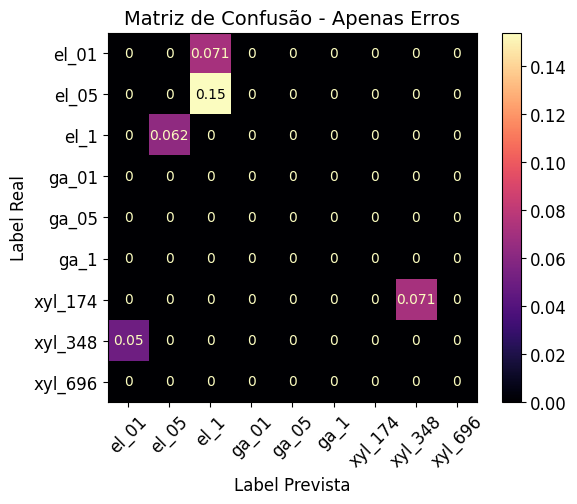

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_best_model.classes_, normalize='true')

# Create error matrix (zero out the diagonal)
error_matrix = cm.copy()
np.fill_diagonal(error_matrix, 0)

# Display the error confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=error_matrix, display_labels=knn_best_model.classes_)
disp.plot(cmap='magma', xticks_rotation=45)

# Axis labels
disp.ax_.set_xlabel("Label Prevista", fontsize=12)
disp.ax_.set_ylabel("Label Real", fontsize=12)
disp.ax_.set_title("Matriz de Confusão - Apenas Erros", fontsize=14)

plt.show()


# conf mat maker

In [ ]:
def make_confmat(df,best_model,dataset,model):
    X = df.drop(["sensor","label"], axis=1)
    y = df.label
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

    # Predict
    y_pred = best_model.predict(X_test)
    

    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap='viridis', xticks_rotation=45)

    # F1-score
    f1 = f1_score(y_test, y_pred, average='macro')
    plt.title(dataset+"\n"+model)
    plt.tight_layout()
    file_name = r"\conf_mat"+"_"+dataset+"_"+model+".png"
    plt.savefig(r"C:\Users\diogo\Desktop\my_lix_conf_mat"+file_name, dpi=300)


<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
C:\Users\diogo\AppData\Local\Temp\ipykernel_39808\415155236.py:19: SyntaxWarning: invalid escape sequence '\c'
  file_name = "\conf_mat"+"_"+dataset+"_"+model+".png"


In [104]:
my_dict = {"xyl":[xyl_results,xyl_df],
           "ga":[gal_results,ga_df],
           "el":[el_results,el_df],
           "AG":[small_label_results,small_label_df],
           "BG":[big_label_results,big_label_df],
           }


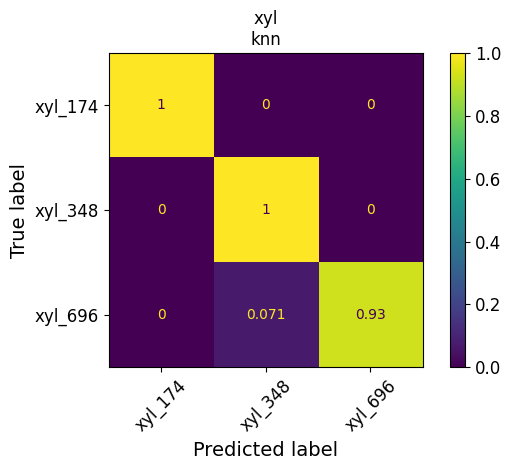

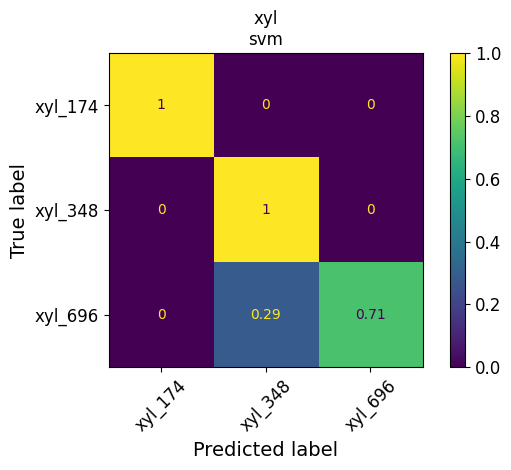

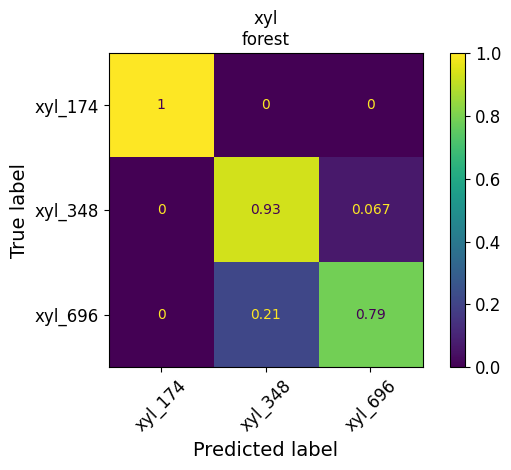

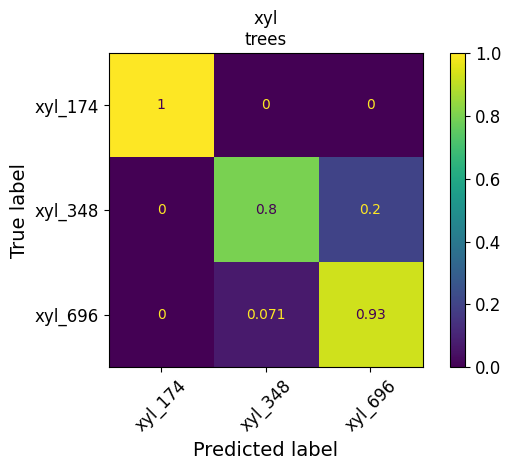

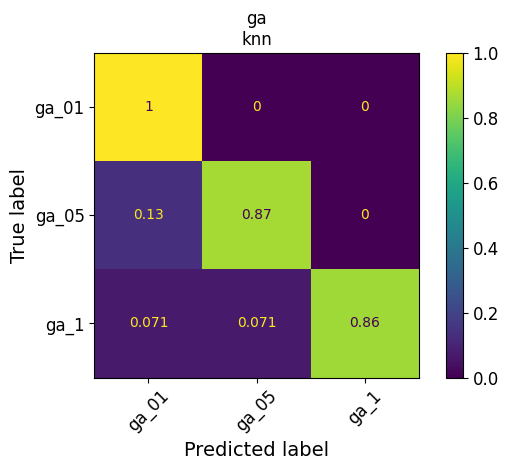

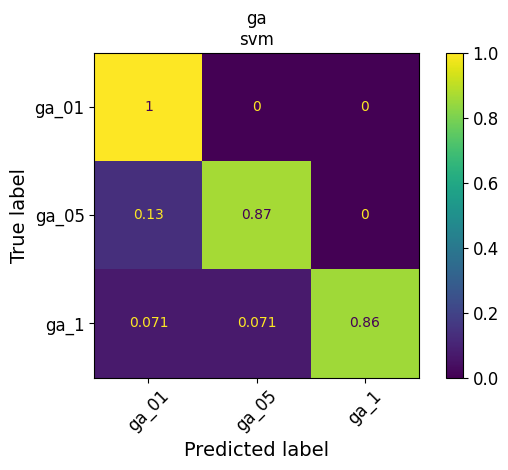

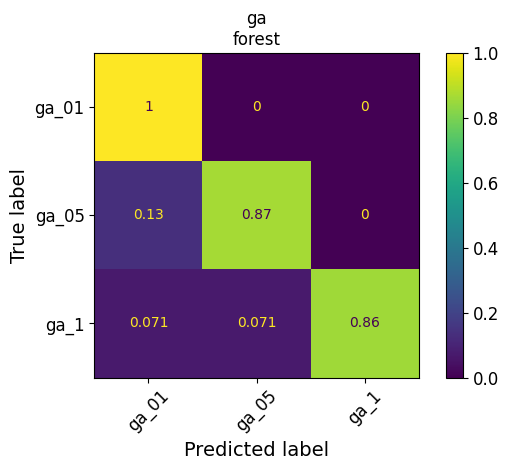

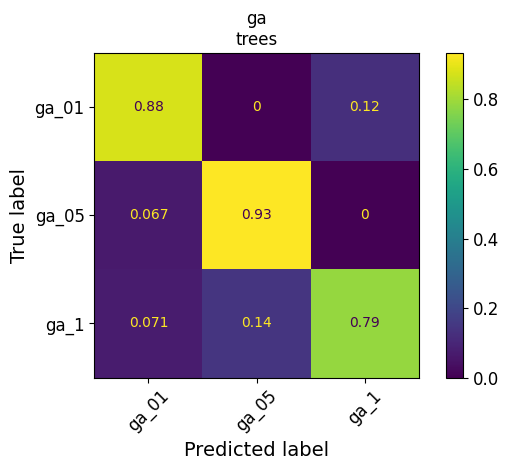

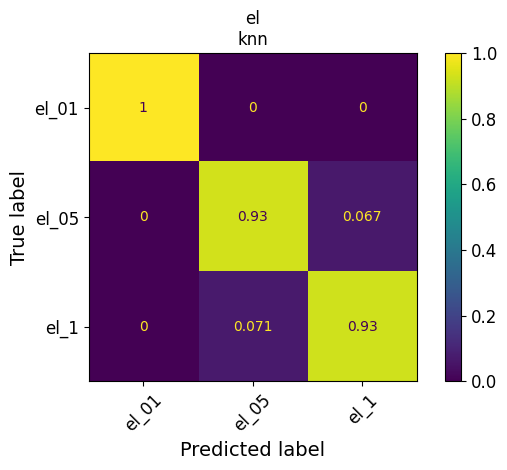

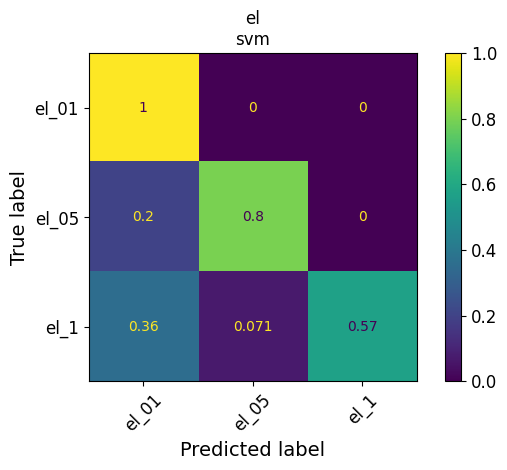

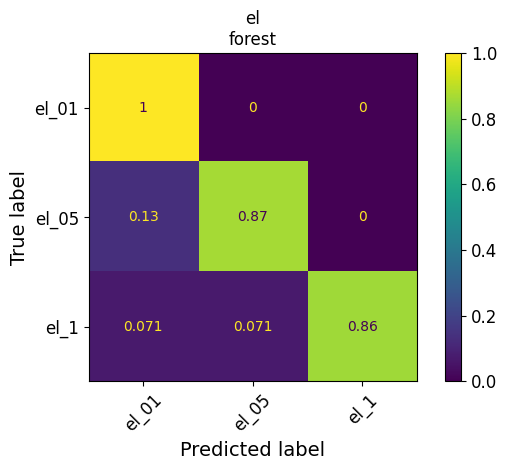

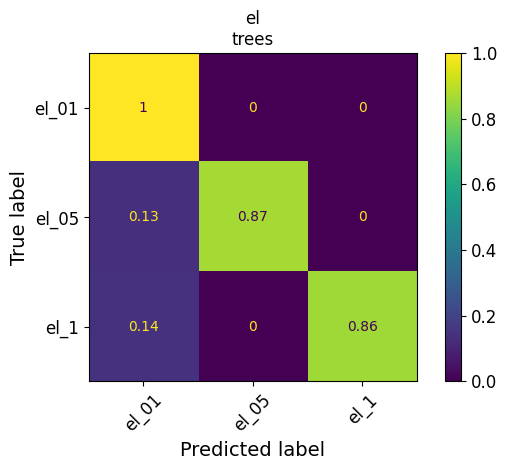

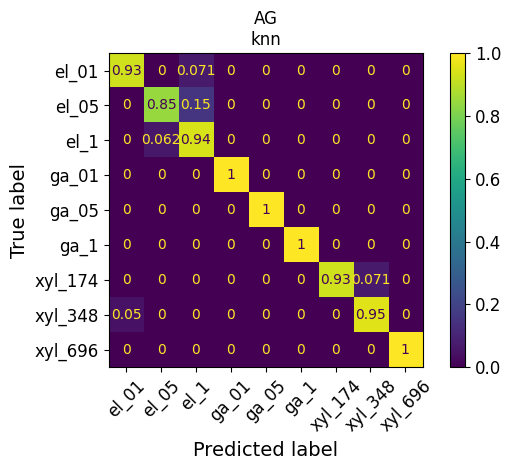

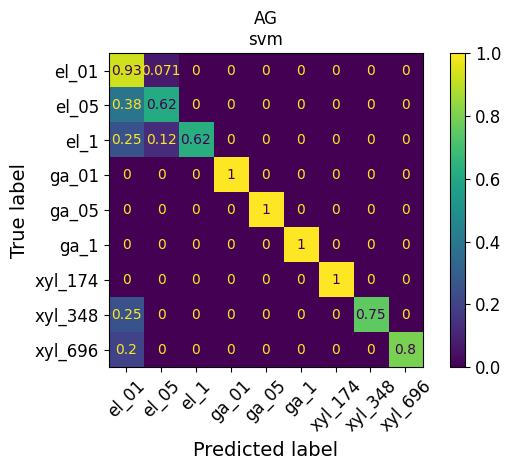

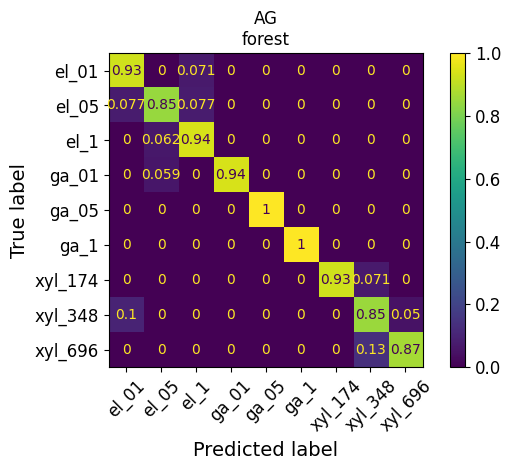

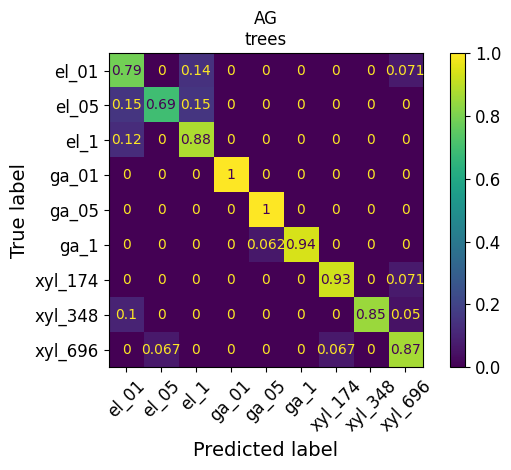

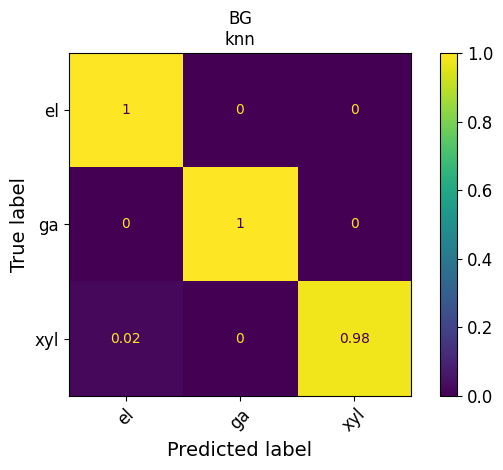

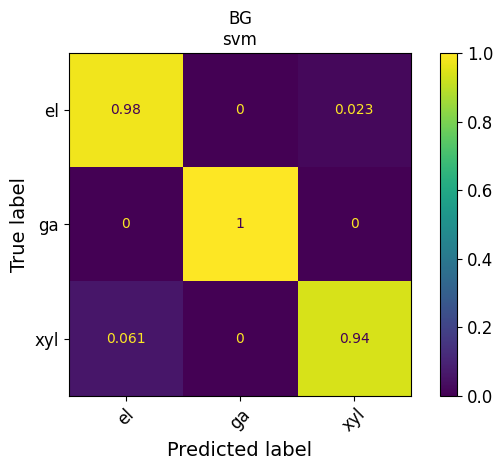

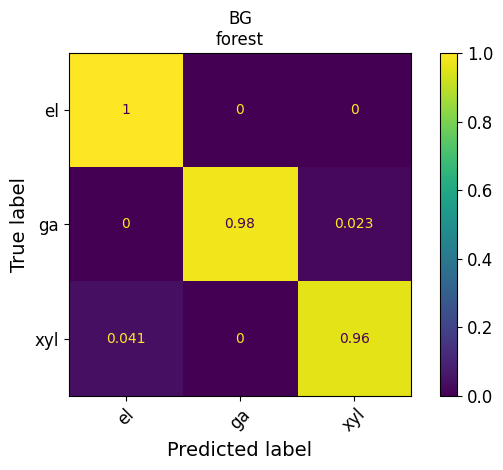

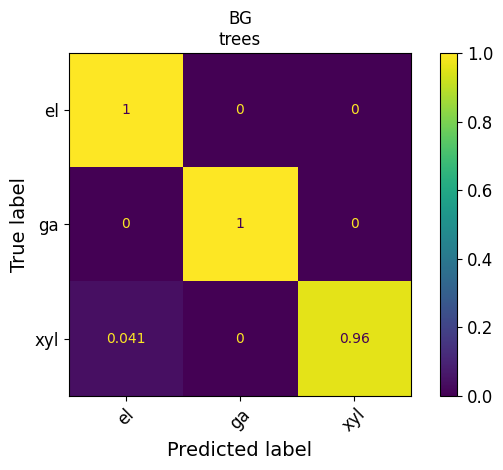

In [105]:
for key in my_dict.keys():
    value = my_dict[key]
    df_name = key
    df_results = value[0]
    df = value[1]
    for ids, row in df_results.iterrows():
            model = row.models
            best_est = row.best_est
            make_confmat(df,best_est,df_name,model)
    


    

In [106]:
value

[   models     score       time  \
 0     knn  0.992593   3.609619   
 1     svm  0.982716  21.481219   
 2  forest  0.992593  76.663738   
 3   trees  0.982716  25.859303   
 
                                             best_est  
 0  (StandardScaler(), KNeighborsClassifier(n_neig...  
 1  (StandardScaler(), SVC(C=50, class_weight='bal...  
 2  (StandardScaler(), (DecisionTreeClassifier(max...  
 3  (StandardScaler(), DecisionTreeClassifier(rand...  ,
     label  sensor         0             1             2             3  \
 60    xyl    6, 7  0.000013  1.299480e-05  1.279410e-05  1.259160e-05   
 61    xyl   9, 10  0.000027  2.635870e-05  2.562070e-05  2.491470e-05   
 62    xyl  15, 27  0.000005  4.858030e-06  4.799660e-06  4.739990e-06   
 63    xyl  27, 17  0.000026  2.531580e-05  2.486370e-05  2.439940e-05   
 64    xyl  17, 18  0.000002  2.313610e-06  2.291420e-06  2.267530e-06   
 ..    ...     ...       ...           ...           ...           ...   
 595    ga   9, 10  0.00